# M2608.001300 Machine Learning<br> Assignment #3 Training Convolutional Neural Networks

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Training a CNN model with Inception modules](#1)
2. [Design a better model on CIFAR-10](#2)

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all three parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a compressed file called *team_#.tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage example: ./*CollectSubmission.sh* &nbsp; team_77)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *Utils* directory. <br>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from utils.data_utils import load_CIFAR10, plot_images
import functools, random, numpy, sys, math

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
    
conf = tf.ConfigProto()
# conf.gpu_options.per_process_gpu_memory_fraction = 0.2
conf.gpu_options.allow_growth = True
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Data has already been downloaded and unpacked.
Train data shape (40000, 32, 32, 3)
Train labels shape (40000,)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000,)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000,)


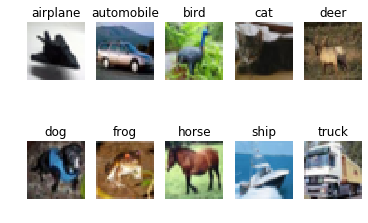

In [2]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, Class_names = load_CIFAR10()
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))
plot_images(X_train, Y_train, Class_names, Each_Category=True)

## <a name="1"></a>1. Training a CNN model with Inception module

In this section, you will implement a little more complex CNN model with an `Inception module` [6]. <br>

![Inception_module](utils/InceptionModule_GoogLeNet.png)

Using the code provided as guidance, <br>
**(1)** Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>
**(2)** Define, train, and evaluate a CNN model with the following architecture and training setup:

#### CNN architecture:
* CNN model consists with stem layer, inception module, and fully connected layer
* Stem layer with
    * conv-pooling-conv-pooling
    * 8 filters for the 9x9 convolutions
    * 3x3 max pooling
* `Inception module` with 
    * 8 filters for the main convolutions (blue blocks in the Figure(a))
    * 3 filters for the dimensionality reduction convolutions (yellow blocks in the Figure(a))
    *  ReLU activation
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate
* Batch size: 500
* Training epoch: 5

In [3]:
def new_weights(shape, name='weight'):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), name=name)

In [4]:
def new_biases(shape, name='bias'):
    return tf.Variable(tf.zeros(shape), name=name)

In [5]:
def new_conv_layer(input,
                  num_input_channel,
                  filter_size,
                  num_filters,
                  use_pooling=False,
                  use_relu=False,
                  use_bn=False) :
    shape = [filter_size, filter_size, num_input_channel, num_filters]
    weights = new_weights(shape)
    biases=new_biases([num_filters])
    
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    
    if use_bn:
        layer = tf.contrib.layers.batch_norm(layer, decay=0.9, updates_collections=None, epsilon=1e-5, scale=False)
    
    if use_pooling :
        pool_size = 2
        pool_stride = 2
        layer = tf.nn.max_pool(value=input,
                               ksize=[1, pool_size, pool_size, 1],
                               strides=[1, pool_stride, pool_stride, 1],
                               padding='SAME')
        
    if use_relu :
        layer = tf.nn.relu(layer)
        
    return layer, weights

In [6]:
def new_pool_layer(input, filter_size):
    layer = tf.nn.max_pool(value=input,
                          ksize=[1, filter_size, filter_size, 1],
                          strides=[1, 1, 1, 1],
                          padding='SAME')
    return layer

In [7]:
def Inception_module(Input, C1, C3_R, C3, C5_R, C5, P3_R):
    '''
    C1, C3, C5: number of filters for the main convolutions
    C3_R, C5_R, P3_R: number of filters for the dimensionality reduction convolutions
    '''
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    input_shape = Input.get_shape().as_list()
    num_input_channel = input_shape[3]
    
    layer_main_conv1, weights_main_conv1 = new_conv_layer(input=Input,
                                                          num_input_channel=num_input_channel,
                                                          filter_size=1,
                                                          num_filters=C1,
                                                          use_pooling=False,
                                                          use_relu=True,
                                                          use_bn=True)
    
    layer_dr_conv_3, weights_dr_conv3 = new_conv_layer(input=Input,
                                                      num_input_channel=num_input_channel,
                                                      filter_size=1,
                                                      num_filters=C3_R,
                                                      use_pooling=False,
                                                      use_relu=True,
                                                      use_bn=True)
    
    layer_main_conv3, weights_main_conv3 = new_conv_layer(input=layer_dr_conv_3,
                                                          num_input_channel=C3_R,
                                                          filter_size=3,
                                                          num_filters=C3,
                                                          use_pooling=False,
                                                          use_relu=True,
                                                          use_bn=True)
    
    layer_dr_conv_5, weights_dr_conv5 = new_conv_layer(input=Input,
                                                      num_input_channel=num_input_channel,
                                                      filter_size=1,
                                                      num_filters=C5_R,
                                                      use_pooling=False,
                                                      use_relu=True,
                                                      use_bn=True)
    
    layer_main_conv5, weights_main_conv5 = new_conv_layer(input=layer_dr_conv_5,
                                                          num_input_channel=C5_R,
                                                          filter_size=5,
                                                          num_filters=C5,
                                                          use_pooling=False,
                                                          use_relu=True,
                                                          use_bn=True)
    
    layer_main_pool = new_pool_layer(input=Input, filter_size=3)
    
    layer_dr_pool, weights_dr_pool = new_conv_layer(input=layer_main_pool,
                                   num_input_channel=num_input_channel,
                                   filter_size=1,
                                   num_filters=P3_R,
                                   use_pooling=False,
                                   use_relu=True,
                                   use_bn=True)
    
    # Shape of each layer must be [num_images, height, width, num_channels]
    # Want to concat with respect to num_channels
    # Therefore, concat axis=3
    Inception = tf.concat([layer_main_conv1, layer_main_conv3, layer_main_conv5, layer_dr_pool], 3)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return Inception


class inception_model(object):
    def __init__(self):
        self.data = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.target = tf.placeholder(tf.float32, [None, 10])

        input_height = 32
        input_width = 32
        num_input_channel = 3
        y_true_size = 10

        layer, stem_weights_1 = new_conv_layer(input=self.data,
                                               num_input_channel=num_input_channel,
                                               filter_size=9,
                                               num_filters=8,
                                               use_pooling=False,
                                               use_relu=True,
                                              use_bn=True)
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer, stem_weights_2 = new_conv_layer(input=layer,
                                               num_input_channel=8,
                                               filter_size=9,
                                               num_filters=8,
                                               use_pooling=False,
                                               use_relu=True,
                                              use_bn=True)
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer = Inception_module(Input=layer,C1=8, C3_R=3, C3=8, C5_R=3, C5=8, P3_R=3)
        
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
        W = new_weights([num_features, y_true_size])
        b = new_biases([y_true_size])

        self.logits = tf.matmul(layer_flat, W)+b
        self.prediction = tf.nn.softmax(self.logits)

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.target)
        self.cost = tf.reduce_mean(cross_entropy)
        self.optimize = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(self.cost)
        
        correct = tf.equal(tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [8]:
def flip_images(sess, X_imgs):
    X_flip = []
    X = tf.placeholder(tf.float32, shape = (32, 32, 3))
    tf_img1 = tf.image.flip_left_right(X)
    for img in X_imgs:
        flipped_img = sess.run(tf_img1, feed_dict = {X: img})
        X_flip.append(flipped_img)
    X_flip = numpy.array(X_flip, dtype = numpy.float32)
    return X_flip

# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
def run_model(session, model, X, Y, epochs=1, batch_size=500, is_training=False, aug=False):
    # For training the model
    sampling_list = list(range(X.shape[0]))

    if is_training:
        if aug :
            # Rotate
            fliped_images = flip_images(session, X)
            X = numpy.concatenate((X, fliped_images), axis=0)
            Y = numpy.concatenate((Y, Y), axis=0)
            print("Augumentation done! size is %d" % X.shape[0])

        for i in range(epochs):
            import datetime
            time1 = datetime.datetime.now()

            sampling_list = list(range(X.shape[0]))
            for j in range(int(X.shape[0] / batch_size)) :
                samplings = random.sample(sampling_list, batch_size)
                sampling_list = [x for x in sampling_list if x not in samplings]

                x_batch = X[samplings]
                y_cls_batch = Y[samplings]

                y_true_batch = tf.one_hot(indices=y_cls_batch, depth=10).eval()

                feed_dict_train = {
                    model.data: x_batch,
                    model.target : y_true_batch
                }

                session.run(model.optimize, feed_dict=feed_dict_train)

            # Error test
            print("Complete %d epoch" % (i + 1))
            print("current batch's loss and accuracy: %f %f" % (session.run(model.cost, feed_dict_train), session.run(model.accuracy, feed_dict_train)))
            
            time2 = datetime.datetime.now()
            print(time2 - time1)

        print("Training done!")

    # Evaluate loss and accuracy of the model
    else :      
        acc_accumulate = 0.0
        for i in range(int(X.shape[0] / batch_size)) :
            samplings = random.sample(sampling_list, batch_size)
            sampling_list = [x for x in sampling_list if x not in samplings]

            x_batch = X[samplings]
            y_cls_batch = Y[samplings]

            y_true_batch = tf.one_hot(indices=y_cls_batch, depth=10).eval()

            feed_dict_train = {
                model.data: x_batch,
                model.target : y_true_batch
            }

            acc_accumulate += session.run(model.accuracy, feed_dict_train)

        accuracy = acc_accumulate / (X.shape[0] / batch_size)

        return session.run(model.cost, feed_dict_train), accuracy

In [36]:
### Clear old variables
tf.reset_default_graph()    

# Declare out simple model
model = inception_model()

# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    run_model(sess, model, X_train, Y_train, is_training=True, epochs=10)

    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))

Complete 1 epoch
current batch's loss and accuracy: 1.717175 0.370000
0:00:09.701265
Complete 2 epoch
current batch's loss and accuracy: 1.547671 0.436000
0:00:10.162412
Complete 3 epoch
current batch's loss and accuracy: 1.518214 0.420000
0:00:10.976148
Complete 4 epoch
current batch's loss and accuracy: 1.424343 0.460000
0:00:11.921174
Complete 5 epoch
current batch's loss and accuracy: 1.308269 0.508000
0:00:12.624425
Complete 6 epoch
current batch's loss and accuracy: 1.346093 0.506000
0:00:13.492549
Complete 7 epoch
current batch's loss and accuracy: 1.250665 0.550000
0:00:14.411825
Complete 8 epoch
current batch's loss and accuracy: 1.275003 0.534000
0:00:15.310318
Complete 9 epoch
current batch's loss and accuracy: 1.217144 0.550000
0:00:18.860474
Complete 10 epoch
current batch's loss and accuracy: 1.171773 0.584000
0:00:19.703522
Training done!
(Loss, Accuracy) on Training Dataset (1.2806, 0.54)
(Loss, Accuracy) on Validataion Dataset (1.3090, 0.52)


## <a name="2"></a>2. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the validation set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation

In [9]:
class my_model(object):
    def __init__(self):
        self.data = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.target = tf.placeholder(tf.float32, [None, 10])

        input_height = 32
        input_width = 32
        num_input_channel = 3
        y_true_size = 10

        layer, _ = new_conv_layer(input=self.data,
                                  num_input_channel=num_input_channel,
                                  filter_size=3,
                                  num_filters=32,
                                  use_pooling=False,
                                  use_relu=True,
                                  use_bn=True)
        layer, _ = new_conv_layer(input=layer,
                                  num_input_channel=32,
                                  filter_size=3,
                                  num_filters=32,
                                  use_pooling=False,
                                  use_relu=True,
                                  use_bn=True)
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer = tf.nn.lrn(layer, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        layer, _ = new_conv_layer(input=layer,
                                               num_input_channel=32,
                                               filter_size=3,
                                               num_filters=64,
                                               use_pooling=False,
                                               use_relu=True,
                                               use_bn=True)
        layer, _ = new_conv_layer(input=layer,
                                               num_input_channel=64,
                                               filter_size=3,
                                               num_filters=64,
                                               use_pooling=False,
                                               use_relu=True,
                                               use_bn=True)
        layer = tf.nn.lrn(layer, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

        layer = Inception_module(Input=layer,C1=8, C3_R=3, C3=8, C5_R=3, C5=8, P3_R=3)
        
        #layer = tf.nn.avg_pool(value=layer,
        #                       ksize=[1,7,7,1],
        #                       strides=[1,1,1,1],
        #                       padding='VALID')
        
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
        W = new_weights([num_features, y_true_size])
        b = new_biases([y_true_size])

        self.logits = tf.matmul(layer_flat, W)+b
        self.prediction = tf.nn.softmax(self.logits)

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.target)
        self.cost = tf.reduce_mean(cross_entropy)
        
        all_vars = tf.trainable_variables()
        lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in all_vars if 'bias' not in v.name])
        self.costL2 = self.cost + lossL2 * 0.01
        
        #global_step = tf.Variable(0, trainable=False)
        #starter_learning_rate = 0.005
        #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
        #                                           100000, 0.96, staircase=True)

        #self.optimize = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.costL2, global_step=global_step)
        self.optimize = tf.train.AdamOptimizer(learning_rate = 0.003).minimize(self.costL2)
        
        correct = tf.equal(tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
# Clear old variables
tf.reset_default_graph()    

# Declare out simple model
model = my_model()    
    
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    run_model(sess, model, X_train, Y_train, is_training=True, epochs=30, aug=True, batch_size=2000)
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))
    
    #Save your final model
    saver = tf.train.Saver()
    saver.save(sess, "./model_checkpoints/my_model_final")

Augumentation done! size is 80000
Complete 1 epoch
current batch's loss and accuracy: 1.111963 0.614000
0:00:44.411785
Complete 2 epoch
current batch's loss and accuracy: 0.826407 0.702000
0:00:41.489427
Complete 3 epoch
current batch's loss and accuracy: 0.778670 0.730000
0:00:41.672295
Complete 4 epoch
current batch's loss and accuracy: 0.650514 0.778000
0:00:41.943728
Complete 5 epoch
current batch's loss and accuracy: 0.589999 0.800500
0:00:42.084038
Complete 6 epoch
current batch's loss and accuracy: 0.580778 0.803000
0:00:42.590895
Complete 7 epoch
current batch's loss and accuracy: 0.529880 0.828500
0:00:42.439789
Complete 8 epoch
current batch's loss and accuracy: 0.522863 0.809500
0:00:42.638572
Complete 9 epoch
current batch's loss and accuracy: 0.437381 0.851000
0:00:43.050359
Complete 10 epoch
current batch's loss and accuracy: 0.473952 0.842000
0:00:43.234051
Complete 11 epoch
current batch's loss and accuracy: 0.441353 0.851500
0:00:43.307780
Complete 12 epoch
current bat

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

_Tell us here_

### Test Set - Do this only once
Now that you've gotten a result that you're happy with, test your final model on the test set. This would be the score you would achieve on a competition. Think about how this compares to your validation set accuracy.

In [12]:
### Clear old variables
tf.reset_default_graph()  

with tf.Session(config=conf) as sess:
    #Load your final model
    model = my_model()
    saver = tf.train.Saver()
    saver.restore(sess, "./model_checkpoints/my_model_final")
    print("(Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % run_model(sess, model, X_test, Y_test))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model_checkpoints/my_model_final
(Loss, Accuracy) on Test Dataset (0.4813, 0.82)
